# Queries

### NOTE: All queries made within the month of January 2010, in the San Diego geographic area
1. What traffic station has the largest difference in average speed over the first two weeks of the month?
2. How significant is the difference in traffic throughput on a rainy Monday vs a non-rainy Monday?
3. Does trace amount of precipitation affect the number of CHP traffic incidents on a given day?  (Trace precipitation is defined as a weather station registering precipitation but less than the unit granularity of the sensor)
4. Identify the top 5 freeways with respect to traffic speed.
5. Is the traffic throughput of one freeway indicative of others?

In [6]:
import dbtemplate as dbt
import numpy as np
import pandas as pd
import pickle
import psycopg2 as pg
import pandas.io.sql as psql
from dbtemplate import StatementExecutorTemplateCallback
from dbtemplate import StatementExecutorTemplate

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
# login_info = {}
# login_info['db_name'] = 
# login_info['username'] = 
# login_info['password'] = 
# login_info['hostname'] = 
# login_info['port'] = 

# with open('pg_login.pkl', 'w') as pfile:
#     pickle.dump(login_info, pfile)

In [9]:
with open('pg_login.pkl') as pfile:
    login_info = pickle.load(pfile)
template = StatementExecutorTemplate(login_info['db_name'], login_info['username'], 
                                    login_info['password'], login_info['hostname'], login_info['port'])

# Results

## 1. What traffic station has the largest difference in average speed over the first two weeks of the month?

In [31]:
class InternalWeekOneCallback(StatementExecutorTemplateCallback):
    def _get_query(self):
        query= """
        SELECT t.pems_id, t.name, avg(o.avg_speed) AS week_one_avg_speed
        FROM traffic_station t
        INNER JOIN observation o on t.id = o.station_id
        WHERE o.time between '2010-01-01 00:00:00' AND '2010-01-07 23:59:59'
        GROUP BY t.pems_id, t.name
        HAVING avg(o.avg_speed) > 0
        """
        return query
    
    def _map_row(self, row):
        m_pems_id, m_traffic_station_name, week_one_avg_speed= row
        return (m_pems_id, m_traffic_station_name, float(week_one_avg_speed))

class InternalWeekTwoCallback(StatementExecutorTemplateCallback):
    def _get_query(self):
        query= """
        SELECT t.pems_id, t.name, avg(o.avg_speed) AS week_two_avg_speed
        FROM traffic_station t
        INNER JOIN observation o on t.id = o.station_id
        WHERE o.time between '2010-01-08 00:00:00' and '2010-01-14 23:59:59'
        GROUP BY t.pems_id, t.name
        HAVING avg(o.avg_speed) > 0
        """
        return query
    
    def _map_row(self, row):
        m_pems_id, m_traffic_station_name, week_two_avg_speed= row
        return (m_pems_id, m_traffic_station_name, float(week_two_avg_speed))

week_one_callback= InternalWeekOneCallback()
week_two_callback= InternalWeekTwoCallback()

m_week_one_list= template.execute(week_one_callback)
m_week_two_list= template.execute(week_two_callback)

week_one_df= dbt.to_data_frame(m_week_one_list, ['pems_id', 'traffic_station_name', 'week_one_avg_speed'])
week_two_df= dbt.to_data_frame(m_week_two_list, ['pems_id', 'traffic_station_name', 'week_two_avg_speed'])

week_one_df['week_one_avg_speed'] = week_one_df['week_one_avg_speed'].astype(float)
week_two_df['week_two_avg_speed'] = week_two_df['week_two_avg_speed'].astype(float)

if week_one_df is None or week_two_df is None:
    print "No Results"
else:
    m_working_df= pd.merge(week_one_df, week_two_df, on=['pems_id', 'traffic_station_name'])
    m_working_df['delta']= m_working_df['week_two_avg_speed'] - m_working_df['week_one_avg_speed']
    m_working_df.sort('delta', ascending=False, inplace=True)
    m_result= m_working_df.iloc[0]
    print m_result

pems_id                           1108491
traffic_station_name    WB MIRA MESA BLVD
week_one_avg_speed               63.32569
week_two_avg_speed               67.39831
delta                            4.072619
Name: 59, dtype: object


Traffic Station with the largest difference across the first two weeks of the month is WB MIRA MESA BLVD station

## 2. How significant is the difference in traffic throughput on a rainy Monday vs a non-rainy Monday?

In [7]:
m_all_mondays= ['2010-01-04', '2010-01-11', '2010-01-18', '2010-01-25']

In [15]:
class InternalRainyDayCallback(StatementExecutorTemplateCallback):
    
    def __init__(self, all_mondays):
        self.m_query_part= ""
        i= 0significant is the difference in traffic throughput on a rainy Monday vs a non-rainy Monday
        for d in all_mondays:
            if i > 0:
                self.m_query_part += ' or '
            self.m_query_part += "p.day = '" + str(d) + "'"
            i+=1
        StatementExecutorTemplateCallback.__init__(self)
        
        
    def _get_query(self):
        query= """
        select p.station_id, p.day, p.amount
        from precipitation_daily_total p
        where p.amount > 0 and ({})
        and p.station_id in (
            select id
            from weather_station
            where ST_Distance(ST_GeographyFromText('SRID=4267;POINT(-117.168347 32.711404)'), Location) < 15 * 1852
        )
        """
        s= query.format(self.m_query_part)
        return s
    
    def _map_row(self, row):
        station_id, day, amount= row
        return (station_id, day, float(amount))

rainy_day_callback= InternalRainyDayCallback(m_all_mondays)

rainy_day_list= template.execute(rainy_day_callback)
rainy_day_df= dbt.to_data_frame(rainy_day_list, ['station_id', 'day', 'amount'])

In [16]:
rainy_day_df

,station_id,day,amount
0,7740,2010-01-18,106


In [17]:
m_rainy_days= rainy_day_df['day'].values.tolist()
for d in m_rainy_days:
    print str(d)

2010-01-18


In [37]:
class InternalRainyDayObservationCallback(StatementExecutorTemplateCallback):
    def __init__(self, rainy_days):
        self.m_query_part= ""
        i= 0
        for d in rainy_days:
            if i > 0:
                self.m_query_part += ' or '
            self.m_query_part += "date(time) = '" + str(d) + "'"
            i+=1
        StatementExecutorTemplateCallback.__init__(self)
    
    def _get_query(self):
        query= """
        select avg(total_flow) as avg_rainy_day_throughput
        from observation
        where
        """
        query+= self.m_query_part
        return query
    
    def _map_row(self, row):
        avg_throughput= row[0]
        return float(avg_throughput)

rainy_day_obs_callback= InternalRainyDayObservationCallback(m_rainy_days)

rainy_day_obs_list= template.execute(rainy_day_obs_callback)
rainy_day_avg_throughput= rainy_day_obs_list[0]
print "rainy_day_avg_throughput=", rainy_day_avg_throughput, "v/5m"

throughput_per_day= rainy_day_avg_throughput * (12 * 24)
print "throughput_per_day=", throughput_per_day

rainy_day_avg_throughput= 113.602239918 v/5m
throughput_per_day= 32717.4450964


In [36]:
class InternalNonRainyDayObservationCallback(StatementExecutorTemplateCallback):
    def __init__(self, non_rainy_days):
        self.m_query_part= ""
        i= 0
        for d in non_rainy_days:
            if i > 0:
                self.m_query_part += ' or '
            self.m_query_part += "date(time) = '" + str(d) + "'"
            i+=1
        StatementExecutorTemplateCallback.__init__(self)
    
    def _get_query(self):
        query= """
        select avg(total_flow) as avg_non_rainy_day_throughput
        from observation
        where
        """
        query+= self.m_query_part
        return query
    
    def _map_row(self, row):
        avg_throughput= row[0]
        return float(avg_throughput)

non_rainy_days= set(m_all_mondays)
for d2 in m_rainy_days:
    d_str= str(d2)
    if d_str in non_rainy_days:
        non_rainy_days.remove(d_str)

non_rainy_day_obs_callback= InternalNonRainyDayObservationCallback(non_rainy_days)

non_rainy_day_obs_list= template.execute(non_rainy_day_obs_callback)
non_rainy_day_avg_throughput= non_rainy_day_obs_list[0]
print "non_rainy_day_avg_throughput=", non_rainy_day_avg_throughput, "v/5m"

throughput_per_day= non_rainy_day_avg_throughput * (12 * 24)
print "throughput_per_day=", throughput_per_day

non_rainy_day_avg_throughput= 141.788926919 v/5m
throughput_per_day= 40835.2109528


In [35]:
delta= non_rainy_day_avg_throughput - rainy_day_avg_throughput
print delta, "vehciles/5m"

delta_per_day= delta * (12 * 24)
print delta_per_day, "vehicles/day"

28.1866870013 vehciles/5m
8117.76585638 vehicles/day


The difference between a rainy Monday and a non-rainy Monday is significant, with an additional throughput of 8117.77 vehicles per day

## 3. Does trace amount of precipitation affect the number of CHP traffic incidents on a given day?  (Trace precipitation is defined as a weather station registering precipitation but less than the unit granularity of the sensor)

In [7]:
connection = pg.connect(dbname=login_info['db_name'], host=login_info['hostname'], user=login_info['username'], password=login_info['password'], port=login_info['port'])

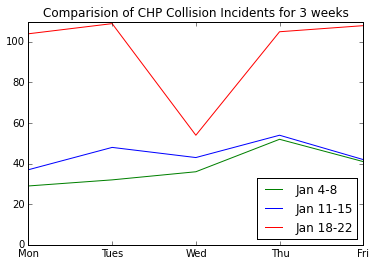

In [8]:
# Number of CHP collision incidents during non-rainy week
df_week1 = psql.read_sql("""
SELECT * 
FROM chp_inc_collision ci
WHERE ci.time between '2010-01-04 00:00:00' AND '2010-01-08 23:59:59'
""", connection)
g = df_week1.groupby(df_week1['time'].dt.normalize())
m_df = g.count()
week1_df = m_df['id']

# Number of CHP collision incidents during non-rainy week
df_week2 = psql.read_sql("""
SELECT * 
FROM chp_inc_collision ci
WHERE ci.time between '2010-01-11 00:00:00' AND '2010-01-15 23:59:59'
""", connection)
g = df_week2.groupby(df_week2['time'].dt.normalize())
week2_df = g.count()['id']

# Number of CHP collision incidents during rainy week
df_week3 = psql.read_sql("""
SELECT *
FROM chp_inc_collision ci
WHERE ci.time between '2010-01-18 00:00:00' AND '2010-01-22 23:59:59'
""", connection)
g = df_week3.groupby(df_week3['time'].dt.normalize())
week3_df = g.count()['id']

# Visually compare number of CHP collisions 2 non-rainy weeks with a rainy week
plt.plot(week1_df.index.dayofweek, week1_df, color = 'green', label="Jan 4-8")
plt.plot(week2_df.index.dayofweek, week2_df, color = 'blue', label="Jan 11-15")
plt.plot(week3_df.index.dayofweek, week3_df, color = 'red', label="Jan 18-22")
plt.ylim(ymin=0)
plt.xticks([0,1,2,3,4], ['Mon','Tues','Wed', 'Thu','Fri'])
plt.legend(loc=4)
plt.title("Comparision of CHP Collision Incidents for 3 weeks")
plt.show()

The figure above shows three separate weeks of CHP collision incidents. The weeks of Jan 4-8 and Jan 11-15 are no precipitation and look very similar. The red line corresponds to a week when there was a lot of rain. It is a little strange that the Wednesday of the rainy week recorded a signifantly less number of collisions than the other days of the week. The trace amount of precipitation occured on Jan 13 (Wed of blue line). As we can see, there a significant deviation from the rest of the week was not observed like the rainy week.

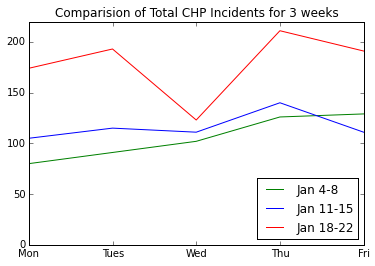

In [9]:
# Number of CHP incidents during non-rainy week
df_week1 = psql.read_sql("""
SELECT * 
FROM chp_inc ci
WHERE ci.time between '2010-01-04 00:00:00' AND '2010-01-08 23:59:59'
""", connection)
g = df_week1.groupby(df_week1['time'].dt.normalize())
m_df = g.count()
week1_df = m_df['id']

# Number of CHP incidents during non-rainy week
df_week2 = psql.read_sql("""
SELECT * 
FROM chp_inc ci
WHERE ci.time between '2010-01-11 00:00:00' AND '2010-01-15 23:59:59'
""", connection)
g = df_week2.groupby(df_week2['time'].dt.normalize())
week2_df = g.count()['id']

# Number of CHP collision incidents during rainy week
df_week3 = psql.read_sql("""
SELECT *
FROM chp_inc ci
WHERE ci.time between '2010-01-18 00:00:00' AND '2010-01-22 23:59:59'
""", connection)
g = df_week3.groupby(df_week3['time'].dt.normalize())
week3_df = g.count()['id']

# Visually compare number of CHP collisions 2 non-rainy weeks with a rainy week
plt.plot(week1_df.index.dayofweek, week1_df, color = 'green', label="Jan 4-8")
plt.plot(week2_df.index.dayofweek, week2_df, color = 'blue', label="Jan 11-15")
plt.plot(week3_df.index.dayofweek, week3_df, color = 'red', label="Jan 18-22")
plt.ylim(ymin=0)
plt.xticks([0,1,2,3,4], ['Mon','Tues','Wed', 'Thu','Fri'])
plt.legend(loc=4)
plt.title("Comparision of Total CHP Incidents for 3 weeks")
plt.show()


To get a comparison of CHP collision incidents to the total number of CHP incidents observed for the same three weeks, the figure above graphs the number of total CHP incidents for the same weeks as the previous figure. The figure shows what the CHP collision incidents show; trace amount of precipitation on Jan 13th is not significantly different than the sunny days.

## 4. Identify the top 5 freeways with respect to traffic speed.

In [10]:
df = psql.read_sql("""
SELECT f.num, f.direction, avg(o.avg_speed) AS avg_speed
        FROM observation o, traffic_station t, freeways f
        WHERE t.id = o.station_id AND
            t.fwy_id = f.id AND
            o.time between '2010-01-01' AND '2010-01-08' AND
            extract(hour from o.time) BETWEEN 15 AND 19 AND
            o.avg_speed > 0
        GROUP BY f.num, f.direction 
        HAVING avg(o.avg_speed) > 0
        ORDER BY avg_speed DESC
        LIMIT 5
""", connection)
df

,num,direction,avg_speed
0,163,S,67.203235
1,94,W,66.629726
2,805,N,66.242472
3,52,W,66.132773
4,8,W,65.970106


For afternoon traffic (15:00 to 19:00), the 5 fastest freeways are show above. 

In [11]:
df = psql.read_sql("""
SELECT f.num, f.direction, avg(o.avg_speed) AS avg_speed
        FROM observation o, traffic_station t, freeways f
        WHERE t.id = o.station_id AND
            t.fwy_id = f.id AND
            o.time between '2010-01-01' AND '2010-01-08' AND
            extract(hour from o.time) BETWEEN 15 AND 19 AND
            o.avg_speed > 0
        GROUP BY f.num, f.direction 
        HAVING avg(o.avg_speed) > 0
        ORDER BY avg_speed ASC
        LIMIT 5
""", connection)
df

,num,direction,avg_speed
0,56,E,56.587540
1,78,E,61.036947
2,8,E,62.415730
3,805,S,62.736001
4,905,W,63.152857


For afternoon traffic (15:00 to 19:00), the 5 slowest freeways are show above. 

In [13]:
connection.close()

## 5. Is the traffic throughput of one freeway indicative of others?

In [2]:
### Start 5 freeway pickle file generation ###

# from sortedcontainers import SortedList

# class Station:
#     def __init__(self, station_id, station_name, lat, lon, ts_length, num_lanes):
#         self.station_id= station_id
#         self.station_name= station_name
#         self.lat= lat
#         self.lon= lon
#         self.ts_length= ts_length
#         self.num_lanes= num_lanes
#         self.observations= SortedList()

# class Observation:
#     def __init__(self, time, throughput):
#         self.time= time
#         self.throughput= throughput
    
#     def __lt__(self, other):
#         return self.time < other.time
    
#     def __le__(self, other):
#         return self.time <= other.time

#     def __eq__(self, other):
#         return self.time == other.time
    
#     def __ne__(self, other):
#         return self.time != other.time

#     def __ge__(self, other):
#         return self.time >= other.time
    
#     def __gt__(self, other):
#         return self.time > other.time
    
# class InternalExtractFreewayCallback(StatementExecutorTemplateCallback):
#     def __init__(self, freeway_num):
#         self.stations= {}
#         self.freeway_num= freeway_num
#         StatementExecutorTemplateCallback.__init__(self)
    
#     def _get_query(self):
#         query= """
#         select ts.id, ts.name, ts.latitude, ts.longitude, ts.length, ts.num_lanes, o.time, o.total_flow
#         from freeways f
#         inner join traffic_station ts on f.id=ts.fwy_id
#         inner join observation o on ts.id=o.station_id
#         where date(o.time) between '2010-01-01' and '2010-01-08'
#         and f.num={}
#         """
#         query= query.format(self.freeway_num)
#         return query
    
#     def process_rows(self, rows):
#         m_stations= self.stations
#         for row in rows:
#             station_id, station_name, lat, lon, ts_length, num_lanes, time, throughput= self._parse_row(row)
#             c_station= None
#             if station_id not in m_stations:
#                 c_station= Station(station_id, station_name, lat, lon, ts_length, num_lanes)
#                 m_stations[station_id]= c_station
#             else:
#                 c_station= m_stations[station_id]
#             o= Observation(time, throughput)
#             c_station.observations.add(o)

#     def _parse_row(self, row):
#         station_id, station_name, lat, lon, ts_length, num_lanes, time, throughput= row
#         return (station_id, station_name, lat, lon, ts_length, num_lanes, long(time.strftime('%s')), throughput)
    
#     def post_intercept(self, results):
#         s= "{}_freeway_map_results.pkl".format(self.freeway_num)
#         print "dumping map to pickle ", s
        
#         with open(s, 'w') as pfile:
#             pickle.dump(self.stations, pfile)
#         results.append(s)

In [3]:
# from collections import OrderedDict

# def create_dataframe(pkl_file_name):
#     m_station_map= None
#     with open(pkl_file_name, 'r') as pfile:
#         m_station_map= pickle.load(pfile)

#     m_df_map= OrderedDict()
#     m_df_map['station_id']= []
#     m_df_map['station_name']= []
#     m_df_map['latitude']= []
#     m_df_map['longitude']= []
#     m_df_map['num_lanes']= []

#     for k,v in m_station_map.iteritems():
#         m_df_map['station_id'].append(v.station_id)
#         m_df_map['station_name'].append(v.station_name)
#         m_df_map['latitude'].append(v.lat)
#         m_df_map['longitude'].append(v.lon)
#         m_df_map['num_lanes'].append(v.num_lanes)
#         l_observations= v.observations
#         for o in l_observations:
#             m_co= None
#             stime= str(o.time)
#             if stime not in m_df_map:
#                 m_co= []
#                 m_df_map[stime]=m_co
#             else:
#                 m_co= m_df_map[stime]
#             m_co.append(o.throughput)
#     m_df= pd.DataFrame(m_df_map)
#     return m_df

In [10]:
# a_df= create_dataframe(pickle_file_name[0])
# a_df

In [11]:
# df_file_name= "{}_freeway_df.pkl".format(freeway_num)
# a_df.to_pickle(df_file_name)

### End logic to generate 5 pickle file ###

In [12]:
m_df= pd.read_pickle('5_freeway_df.pkl')
m_df

,station_id,station_name,latitude,longitude,num_lanes,1262332800,1262333100,1262333400,1262333700,1262334000,...,1263021000,1263021300,1263021600,1263021900,1263022200,1263022500,1263022800,1263023100,1263023400,1263023700
0,1,SEA WORLD DR,32.767779,-117.205941,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,CLAIREMONT DR,32.788206,-117.206890,1,17,6,8,11,15,...,23,29,23,12,15,15,10,13,18,14
2,3,DEL MAR HTS RD,32.947766,-117.243147,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,VIA DE LA VALLE,32.976740,-117.251751,2,8,11,6,6,12,...,13,21,7,7,14,7,16,6,9,15
4,5,LOMAS SANTA FE,32.993716,-117.256045,2,3,5,5,5,6,...,4,8,5,10,8,11,4,5,12,10
5,6,MANCHESTER AVE,33.010779,-117.265010,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,PALOMAR AIRPORT RD,33.119570,-117.320309,3,0,3,5,10,7,...,8,7,14,8,9,6,4,1,6,10
7,8,OLD TOWN/HANCOCK,32.748777,-117.195062,1,3,9,3,6,5,...,6,6,6,9,9,12,11,2,4,7
8,9,CLAIREMONT DR,32.791267,-117.207352,2,16,2,5,7,14,...,14,10,10,15,12,13,12,12,10,7
9,10,GILMAN DR to 5SB,32.848532,-117.235725,2,1,0,1,2,5,...,1,2,0,1,4,2,1,1,4,2


In [13]:
m_df.drop(['station_id', 'station_name'], axis=1, inplace=True)
m_df

,latitude,longitude,num_lanes,1262332800,1262333100,1262333400,1262333700,1262334000,1262334300,1262334600,...,1263021000,1263021300,1263021600,1263021900,1263022200,1263022500,1263022800,1263023100,1263023400,1263023700
0,32.767779,-117.205941,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32.788206,-117.206890,1,17,6,8,11,15,18,22,...,23,29,23,12,15,15,10,13,18,14
2,32.947766,-117.243147,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,32.976740,-117.251751,2,8,11,6,6,12,11,12,...,13,21,7,7,14,7,16,6,9,15
4,32.993716,-117.256045,2,3,5,5,5,6,9,17,...,4,8,5,10,8,11,4,5,12,10
5,33.010779,-117.265010,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,33.119570,-117.320309,3,0,3,5,10,7,10,10,...,8,7,14,8,9,6,4,1,6,10
7,32.748777,-117.195062,1,3,9,3,6,5,5,9,...,6,6,6,9,9,12,11,2,4,7
8,32.791267,-117.207352,2,16,2,5,7,14,7,12,...,14,10,10,15,12,13,12,12,10,7
9,32.848532,-117.235725,2,1,0,1,2,5,1,0,...,1,2,0,1,4,2,1,1,4,2


(285, 285)
[  9.12858757e-01   3.68001427e-02   1.66363205e-02   6.23034280e-03
   3.71667122e-03   3.13012937e-03   2.38365350e-03   1.81826247e-03
   1.51884674e-03   1.08825764e-03   9.44211617e-04   9.30162196e-04
   7.59699456e-04   7.02125558e-04   5.93995651e-04   4.75921283e-04
   4.47300542e-04   4.12956826e-04   3.77589677e-04   3.51508965e-04
   3.28706336e-04   3.17621754e-04   2.91547448e-04   2.62691980e-04
   2.42563691e-04   2.34212454e-04   2.25752636e-04   1.93555954e-04
   1.92649210e-04   1.75174798e-04   1.70806758e-04   1.65648074e-04
   1.55434390e-04   1.49208087e-04   1.44303877e-04   1.31564167e-04
   1.25346846e-04   1.20512580e-04   1.15316956e-04   1.08411737e-04
   1.04941177e-04   1.00526979e-04   9.74856245e-05   9.59397571e-05
   9.13610174e-05   8.45292364e-05   8.12189024e-05   7.79784546e-05
   7.54384177e-05   7.20366683e-05   6.86266683e-05   6.70954046e-05
   6.35799647e-05   6.09179309e-05   6.08452377e-05   5.86847098e-05
   5.42688110e-05   5.3

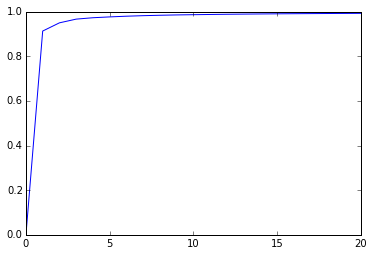

In [14]:
from sklearn.decomposition import PCA
pca= PCA(n_components=len(m_df.columns))
m_result= pca.fit_transform(m_df)
print shape(m_result)
print(pca.explained_variance_ratio_)
result_eigvalues= pca.explained_variance_ratio_

k= 20
#k= len(m_df.columns)
m_plot_arr = ([0, ] + list(np.cumsum(result_eigvalues[:k]))) / sum(result_eigvalues)

print m_plot_arr
    
plt.plot(m_plot_arr)

In [15]:
m_eigs= pca.components_[0:k]
m_eigs_transpose= np.matrix(np.transpose(m_eigs))
Eig= np.matrix(m_eigs)

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt

def _scatter_proj(l_proj, ttl):
    f1= l_proj[:,0]
    f2= l_proj[:,1]
    # f3= m_projection[:,2]

    # class1_sample.shape -> (20, 3), 20 rows, 3 columns

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    #ax.scatter(f1, f2, f3, marker='x', color='blue', s=40, label='class 1')
    ax.scatter(f1, f2, marker='x', color='blue')

    ax.set_xlabel('V1')
    ax.set_ylabel('V2')
    # ax.set_zlabel('V3')

    plt.title(ttl)

    plt.show()

In [17]:
def _cost_function(rec_row, orig_row):
    a= np.array(rec_row)
    b= np.array(orig_row)
    n= float(len(rec_row))
    return (((a-b)**2).sum()) / n

In [18]:
def project_reconstruct(freeway_num, l_df, l_eigs_transpose, l_Eig):
    l_ttl= 'Freeway{}'.format(freeway_num)
    m_orig_values= np.matrix(l_df.values)

    m_projection= m_orig_values * l_eigs_transpose
    _scatter_proj(m_projection, l_ttl)

    l_rec = np.array(m_projection * l_Eig)
    
    return l_rec

In [19]:
import random

def graph_orig_rec(l_rec, l_df, freeway_num):
    l_orig_values= np.matrix(l_df.values)
    
    m_random_rows= set()
    i= 0
    while i < 5:
        m_rand_int= random.randint(0, len(l_rec) - 1)
        if m_rand_int not in m_random_rows:
            m_random_rows.add(m_rand_int)
            i+=1

    j= 0
    for sample_row_index in m_random_rows:
        fig, ax = plt.subplots()
        row_id= str(sample_row_index)

        m_orig_first_row= l_orig_values[sample_row_index].A[0]
        m_rec_first_row= l_rec[sample_row_index]
        
        cost= _cost_function(m_rec_first_row, m_orig_first_row)
        s= "Freeway {}, Row {}, mean square error={}".format(freeway_num, row_id, cost)

        x_list= []
        for i in xrange(len(m_rec_first_row)):
            x_list.append(i)

        ax.plot(x_list, m_orig_first_row, c='b', label='original')
        ax.plot(x_list, m_rec_first_row, c='g', label='reconstruction')
        ax.set_xlabel('timestep')
        ax.set_ylabel('throughput')
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
        ax.set_title(s)
        j+=1

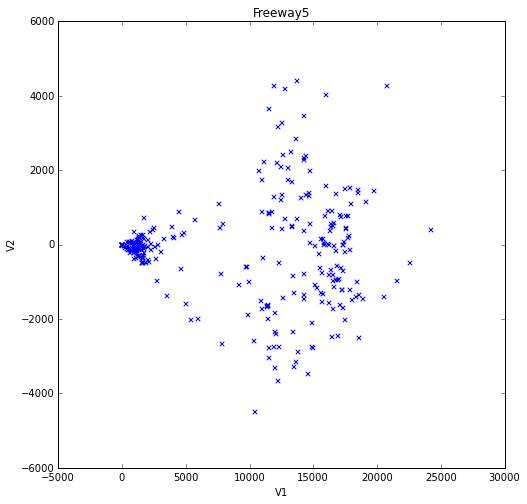

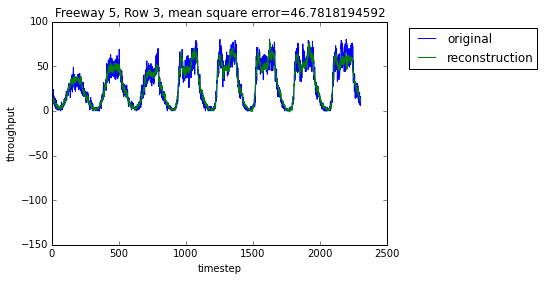

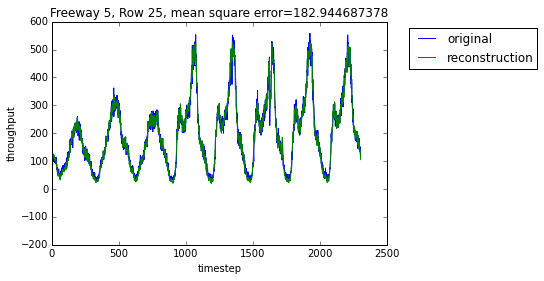

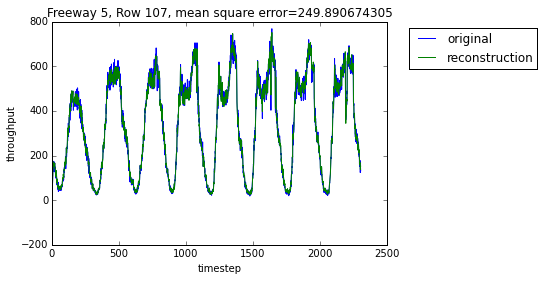

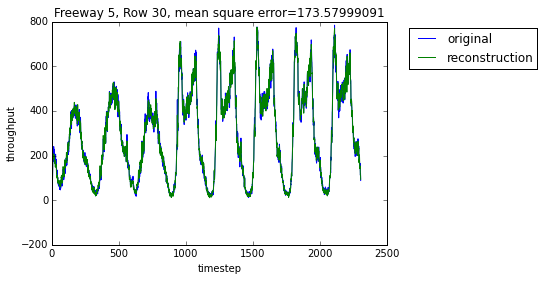

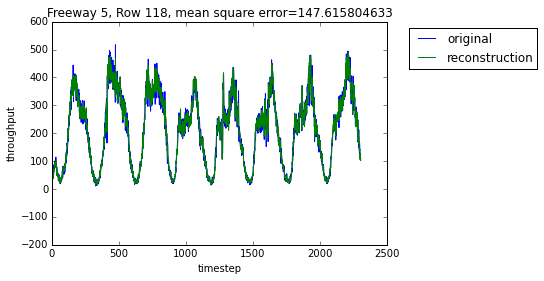

In [20]:
freeway_num= 5
rec= project_reconstruct(freeway_num, m_df, m_eigs_transpose, Eig)
graph_orig_rec(rec, m_df, freeway_num)

In [21]:
### Logic to create DF pickles for 8, 15, 56, 805 freeways ###

# other_freeways= [8, 15, 56, 805]

# for f in other_freeways:
#     pickle_file_name= template.execute(InternalExtractFreewayCallback(f))
#     print pickle_file_name
#     a_df= create_dataframe(pickle_file_name[0])
#     df_file_name= "{}_freeway_df.pkl".format(f)
#     a_df.to_pickle(df_file_name)

### End Logic to create DF pickles for 8, 15, 56, 805 freeways ###

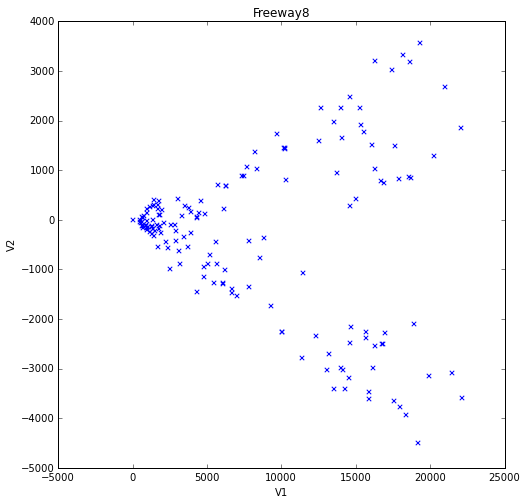

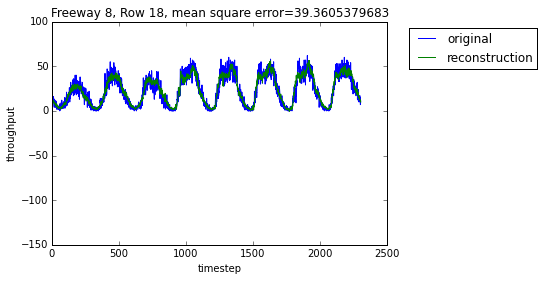

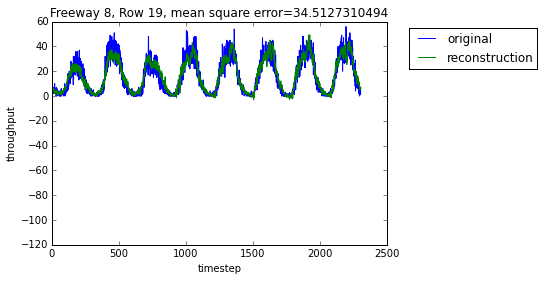

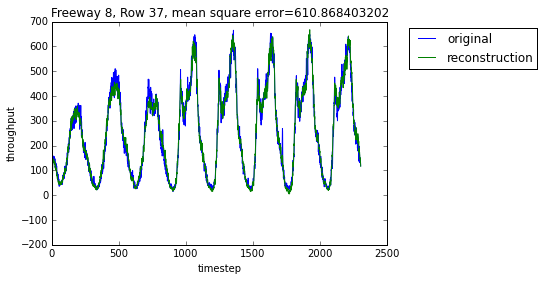

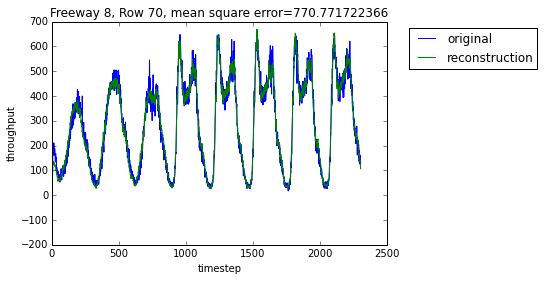

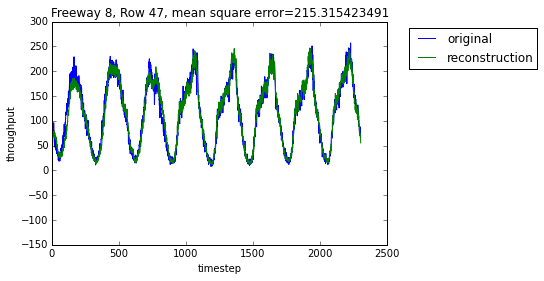

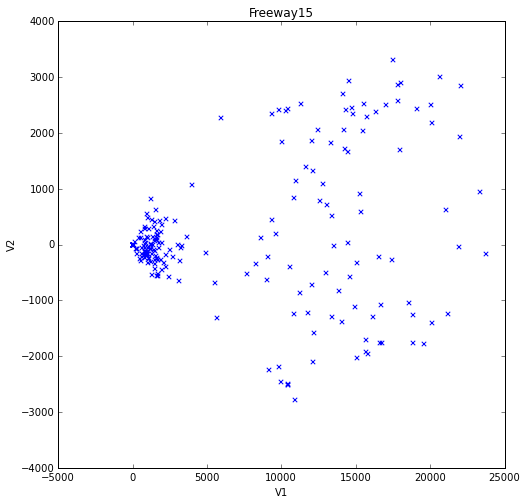

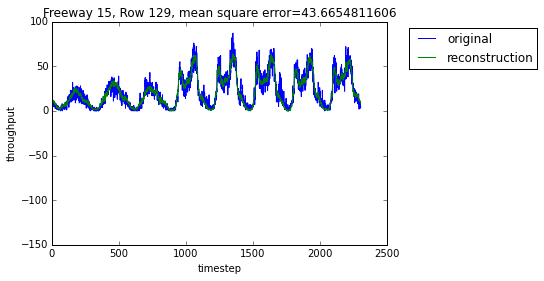

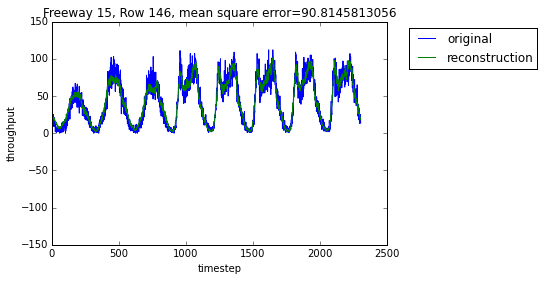

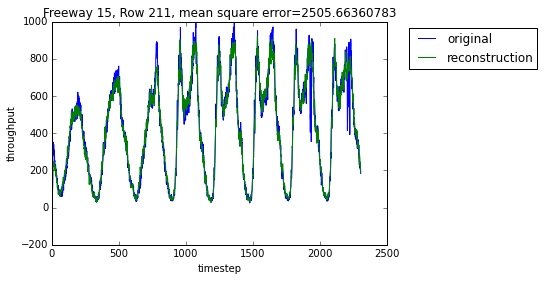

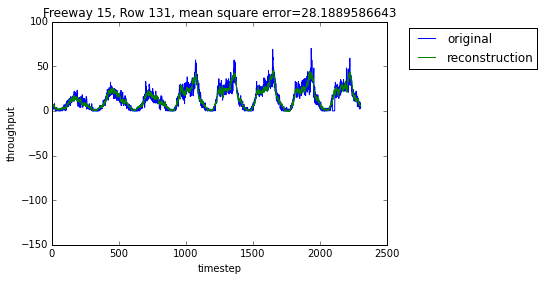

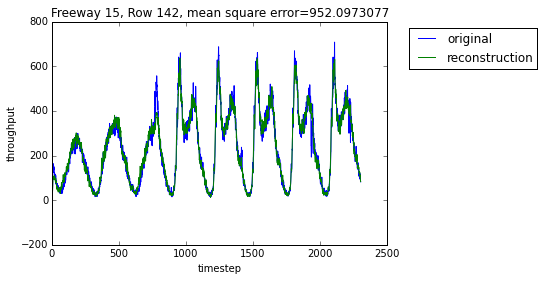

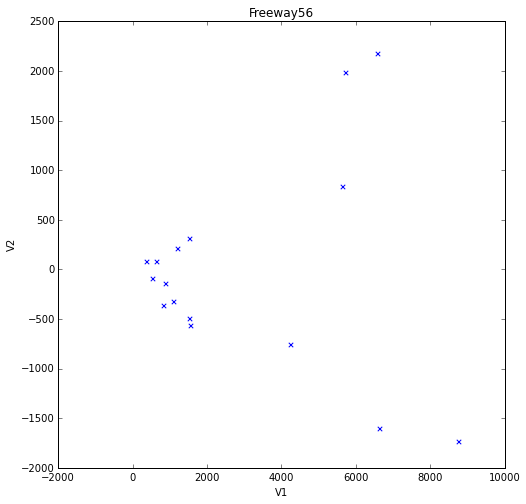

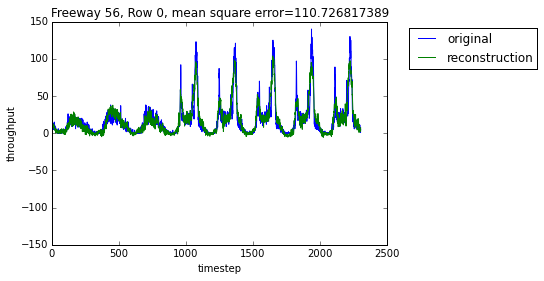

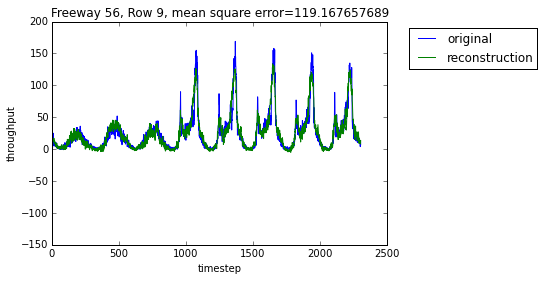

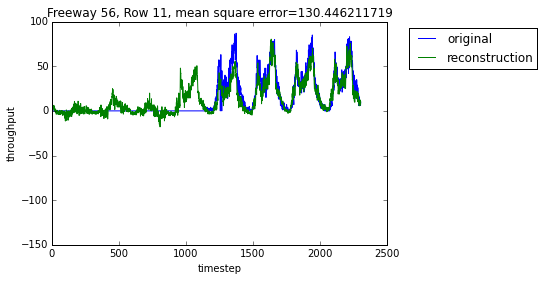

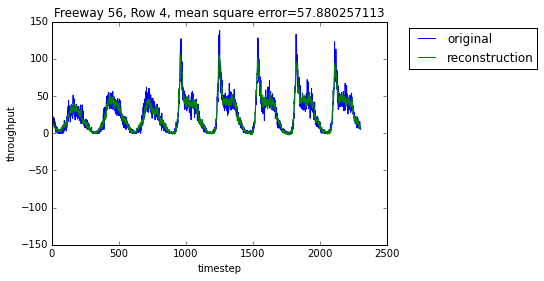

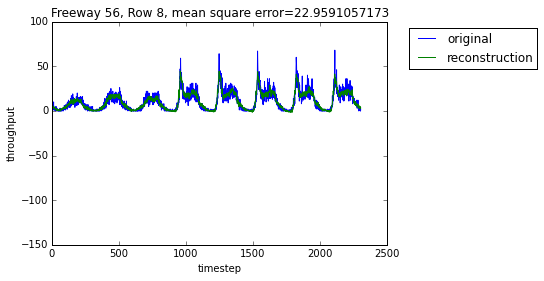

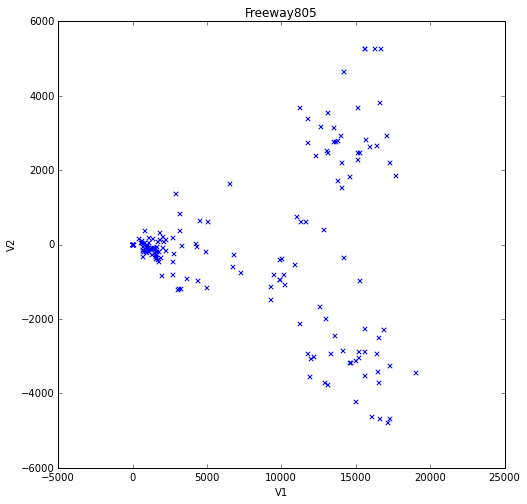

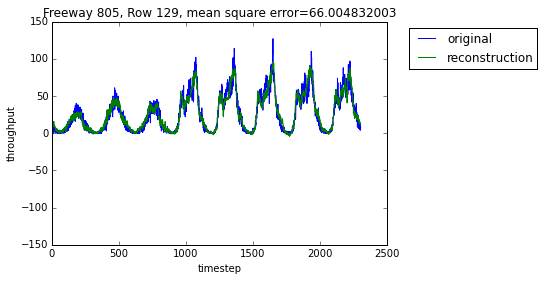

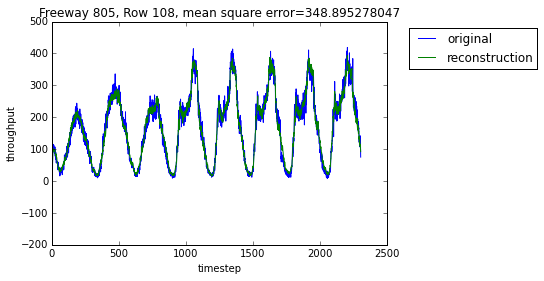

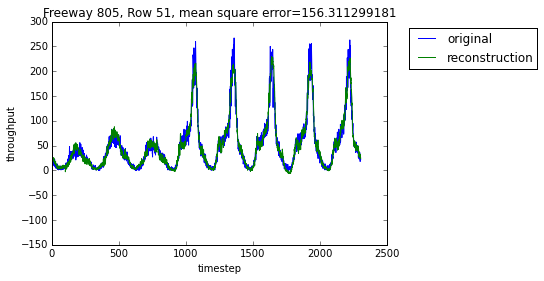

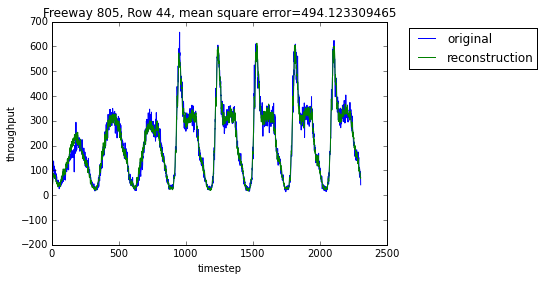

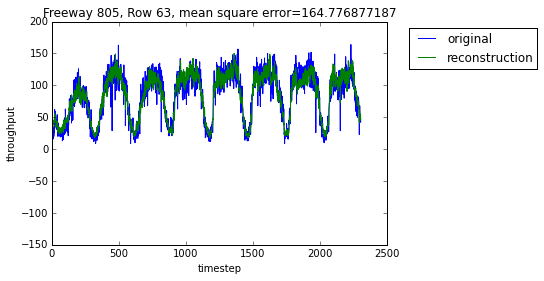

In [22]:
other_freeways= [8, 15, 56, 805]

for f in other_freeways:
    pkl_name= '{}_freeway_df.pkl'.format(f)
    df= pd.read_pickle(pkl_name)
    df.drop(['station_id', 'station_name'], axis=1, inplace=True)
    rec= project_reconstruct(f, df, m_eigs_transpose, Eig)
    graph_orig_rec(rec, df, f)

The following plots depict the reconstruction of random station readings from the 8, 15, 56, 805 freeways using the top 2 principal components of the 5 freeway in the first week of January 2010. From the results, the line plots exhibits minimal MSE betweeen the reconstruction and the original station throughput readings. This implies, that the throughput of one freeway is indicative of others